In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import display
from IPython.display import display
import unidecode
import seaborn as sns
from io import StringIO
import re
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import copy
from googletrans import Translator
#import nltk  
#nltk.download() 

In [146]:
with open('train.json', 'r') as myfile:
    data=myfile.read()

    # parse file
obj = json.loads(data)
df = pd.DataFrame(obj)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15555 entries, 0 to 15554
Data columns (total 6 columns):
claim               15555 non-null object
claimant            15555 non-null object
date                15555 non-null object
id                  15555 non-null int64
label               15555 non-null int64
related_articles    15555 non-null object
dtypes: int64(2), object(4)
memory usage: 729.2+ KB


In [148]:
df.head(5)

,claim,claimant,date,id,label,related_articles
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


In [149]:
df['word_count'] = df['claim'].apply(lambda x: len(str(x).split(" ")))

df[['claim', 'word_count']].sort_values(by=['word_count'], ascending=False).head(5)

,claim,word_count
10689,A list circulating online contains 50 false st...,1511
10854,Account describes a cab driver taking an elder...,1167
14945,A California Senate bill gives the state the r...,1124
4031,The U.S. Congress is considering passage of th...,1021
714,A virus deadly to dogs has been spreading in t...,1012


In [150]:
df['char_count'] = df['claim'].str.len()

df[['claim', 'char_count']].sort_values(by=['char_count'], ascending=False).head(5)

,claim,char_count
10689,A list circulating online contains 50 false st...,8562
14945,A California Senate bill gives the state the r...,7341
4031,The U.S. Congress is considering passage of th...,6745
10854,Account describes a cab driver taking an elder...,6339
714,A virus deadly to dogs has been spreading in t...,5811


In [151]:
def avg_word(sentence):
    words = sentence.split()
    avg_words = 0
    
    if len(words) != 0:
        avg_words = (sum(len(word) for word in words) / len(words))
    else:
        avg_words = 0
    return avg_words

df['avg_word'] = df['claim'].apply(lambda x: avg_word(x))

df[['claim', 'avg_word']].sort_values(by=['avg_word'], ascending=False).head(5)

,claim,avg_word
10653,"""Pelosi Issues ‘Impeachment’ Announcement.""",10.000000
11453,"Says Dan Patrick ""proposed Arizona-style show-...",9.714286
656,Bristol Palin said performers were afraid perf...,9.483871
11256,Is Coca-Cola Considering Cannabis-Infused Beve...,9.400000
12980,"California ""is hemorrhaging population.""",9.250000


In [152]:
# Number of stopwords

stop = stopwords.words('english', 'spanish')
df['stopwords'] = df['claim'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['claim', 'stopwords']].sort_values(by=['stopwords'], ascending=False).head(5)

,claim,stopwords
10854,Account describes a cab driver taking an elder...,509
8682,"""Hitmen"" who have been hired to kill you chang...",492
10689,A list circulating online contains 50 false st...,487
714,A virus deadly to dogs has been spreading in t...,451
14945,A California Senate bill gives the state the r...,443


In [153]:
# Number of numerics
df['numerics'] = df['claim'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['claim', 'numerics']].sort_values(by=['numerics'], ascending=False).head(5)

,claim,numerics
783,President Obama has issued a whopping 923 exec...,48
12547,A list of coincidences connecting the number 1...,20
1501,Barack Obama is the only president who has fai...,18
10689,A list circulating online contains 50 false st...,14
1393,Muslims recently decided to celebrate the birt...,13


In [155]:
# Determine average reduction in text claim
line=3597
df['claim'][line]

'Says David Jolly lobbied "for government-run health care just last year."'

In [156]:
# Define function calculating average length of sentence
def getAvgLen(sentences):
    length = []    
    for sentence in sentences:
        length.append(len(sentence))
    avg_length = np.mean(length)    
    return avg_length

In [157]:
# Get the average length of each description
avg_len_beg = getAvgLen(df['claim'])
print('Average claim length: {}'.format(round(avg_len_beg, 2)))

Average claim length: 144.52


In [158]:
# Remove boilerplate translation comments & HTML tags
df['normalized_en'] = df['claim'].apply(lambda x: re.sub('<i>.*?</i>', ' ', x, flags=re.DOTALL))

# Remove HTML with BeautifulSoup
df['normalized_en'] = df['claim'].apply(lambda x: BeautifulSoup(x, "lxml").get_text())

# Remove special characters
df['normalized_en'] = df['claim'].apply(lambda x: re.sub('\r\n', ' ', x, flags=re.DOTALL))

print("\n")
df['normalized_en'][line]

'Says David Jolly lobbied "for government-run health care just last year."'

In [159]:
# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])

print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Reduction in average claim length: 0.0%


In [160]:
# Remove non-English text
df['normalized_en'] = df['normalized_en'].apply(lambda x: re.sub('(.*)(Translated by)', ' ', x, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda x: re.sub('(Translation from).*', ' ', x, flags=re.DOTALL))

df['normalized_en'][line]

'Says David Jolly lobbied "for government-run health care just last year."'

In [18]:
translatedList = []
for index, row in df.iterrows():
   # REINITIALIZE THE API
    translator = Translator()
    newrow = copy.deepcopy(row)
    try:
       # translate the 'text' column
        translated = translator.translate(row['normalized_en'], dest='en')
        newrow['translated'] = translated.text
    except Exception as e:
        print(str(e))
        continue
    translatedList.append(newrow)

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (

In [19]:
# got list from http://www.tysto.com/uk-us-spelling-list.html
normalized_dict = {
    "accessorise" : "accessorize",
    "accessorised" : "accessorized",
    "accessorises" : "accessorizes",
    "accessorising" : "accessorizing",
    "acclimatisation" : "acclimatization",
    "acclimatise" : "acclimatize",
    "acclimatised" : "acclimatized",
    "acclimatises" : "acclimatizes",
    "acclimatising" : "acclimatizing",
    "accoutrements" : "accouterments",
    "aeon" : "eon",
    "aeons" : "eons",
    "aerogramme" : "aerogram",
    "aerogrammes" : "aerograms",
    "aeroplane" : "airplane",
    "aeroplanes" : "airplanes",
    "aesthete" : "esthete",
    "aesthetes" : "esthetes",
    "aesthetic" : "esthetic",
    "aesthetically" : "esthetically",
    "aesthetics" : "esthetics",
    "aetiology" : "etiology",
    "ageing" : "aging",
    "aggrandisement" : "aggrandizement",
    "agonise" : "agonize",
    "agonised" : "agonized",
    "agonises" : "agonizes",
    "agonising" : "agonizing",
    "agonisingly" : "agonizingly",
    "almanack" : "almanac",
    "almanacks" : "almanacs",
    "aluminium" : "aluminum",
    "amortisable" : "amortizable",
    "amortisation" : "amortization",
    "amortisations" : "amortizations",
    "amortise" : "amortize",
    "amortised" : "amortized",
    "amortises" : "amortizes",
    "amortising" : "amortizing",
    "amphitheatre" : "amphitheater",
    "amphitheatres" : "amphitheaters",
    "anaemia" : "anemia",
    "anaemic" : "anemic",
    "anaesthesia" : "anesthesia",
    "anaesthetic" : "anesthetic",
    "anaesthetics" : "anesthetics",
    "anaesthetise" : "anesthetize",
    "anaesthetised" : "anesthetized",
    "anaesthetises" : "anesthetizes",
    "anaesthetising" : "anesthetizing",
    "anaesthetist" : "anesthetist",
    "anaesthetists" : "anesthetists",
    "anaesthetize" : "anesthetize",
    "anaesthetized" : "anesthetized",
    "anaesthetizes" : "anesthetizes",
    "anaesthetizing" : "anesthetizing",
    "analogue" : "analog",
    "analogues" : "analogs",
    "analyse" : "analyze",
    "analysed" : "analyzed",
    "analyses" : "analyzes",
    "analysing" : "analyzing",
    "anglicise" : "anglicize",
    "anglicised" : "anglicized",
    "anglicises" : "anglicizes",
    "anglicising" : "anglicizing",
    "annualised" : "annualized",
    "antagonise" : "antagonize",
    "antagonised" : "antagonized",
    "antagonises" : "antagonizes",
    "antagonising" : "antagonizing",
    "apologise" : "apologize",
    "apologised" : "apologized",
    "apologises" : "apologizes",
    "apologising" : "apologizing",
    "appal" : "appall",
    "appals" : "appalls",
    "appetiser" : "appetizer",
    "appetisers" : "appetizers",
    "appetising" : "appetizing",
    "appetisingly" : "appetizingly",
    "arbour" : "arbor",
    "arbours" : "arbors",
    "archaeological" : "archeological",
    "archaeologically" : "archeologically",
    "archaeologist" : "archeologist",
    "archaeologists" : "archeologists",
    "archaeology" : "archeology",
    "ardour" : "ardor",
    "armour" : "armor",
    "armoured" : "armored",
    "armourer" : "armorer",
    "armourers" : "armorers",
    "armouries" : "armories",
    "armoury" : "armory",
    "artefact" : "artifact",
    "artefacts" : "artifacts",
    "authorise" : "authorize",
    "authorised" : "authorized",
    "authorises" : "authorizes",
    "authorising" : "authorizing",
    "axe" : "ax",
    "backpedalled" : "backpedaled",
    "backpedalling" : "backpedaling",
    "bannister" : "banister",
    "bannisters" : "banisters",
    "baptise" : "baptize",
    "baptised" : "baptized",
    "baptises" : "baptizes",
    "baptising" : "baptizing",
    "bastardise" : "bastardize",
    "bastardised" : "bastardized",
    "bastardises" : "bastardizes",
    "bastardising" : "bastardizing",
    "battleaxe" : "battleax",
    "baulk" : "balk",
    "baulked" : "balked",
    "baulking" : "balking",
    "baulks" : "balks",
    "bedevilled" : "bedeviled",
    "bedevilling" : "bedeviling",
    "behaviour" : "behavior",
    "behavioural" : "behavioral",
    "behaviourism" : "behaviorism",
    "behaviourist" : "behaviorist",
    "behaviourists" : "behaviorists",
    "behaviours" : "behaviors",
    "behove" : "behoove",
    "behoved" : "behooved",
    "behoves" : "behooves",
    "bejewelled" : "bejeweled",
    "belabour" : "belabor",
    "belaboured" : "belabored",
    "belabouring" : "belaboring",
    "belabours" : "belabors",
    "bevelled" : "beveled",
    "bevvies" : "bevies",
    "bevvy" : "bevy",
    "biassed" : "biased",
    "biassing" : "biasing",
    "bingeing" : "binging",
    "bougainvillaea" : "bougainvillea",
    "bougainvillaeas" : "bougainvilleas",
    "bowdlerise" : "bowdlerize",
    "bowdlerised" : "bowdlerized",
    "bowdlerises" : "bowdlerizes",
    "bowdlerising" : "bowdlerizing",
    "breathalyse" : "breathalyze",
    "breathalysed" : "breathalyzed",
    "breathalyser" : "breathalyzer",
    "breathalysers" : "breathalyzers",
    "breathalyses" : "breathalyzes",
    "breathalysing" : "breathalyzing",
    "brutalise" : "brutalize",
    "brutalised" : "brutalized",
    "brutalises" : "brutalizes",
    "brutalising" : "brutalizing",
    "buses" : "busses",
    "busing" : "bussing",
    "caesarean" : "cesarean",
    "caesareans" : "cesareans",
    "calibre" : "caliber",
    "calibres" : "calibers",
    "calliper" : "caliper",
    "callipers" : "calipers",
    "callisthenics" : "calisthenics",
    "canalise" : "canalize",
    "canalised" : "canalized",
    "canalises" : "canalizes",
    "canalising" : "canalizing",
    "cancellation" : "cancelation",
    "cancellations" : "cancelations",
    "cancelled" : "canceled",
    "cancelling" : "canceling",
    "candour" : "candor",
    "cannibalise" : "cannibalize",
    "cannibalised" : "cannibalized",
    "cannibalises" : "cannibalizes",
    "cannibalising" : "cannibalizing",
    "canonise" : "canonize",
    "canonised" : "canonized",
    "canonises" : "canonizes",
    "canonising" : "canonizing",
    "capitalise" : "capitalize",
    "capitalised" : "capitalized",
    "capitalises" : "capitalizes",
    "capitalising" : "capitalizing",
    "caramelise" : "caramelize",
    "caramelised" : "caramelized",
    "caramelises" : "caramelizes",
    "caramelising" : "caramelizing",
    "carbonise" : "carbonize",
    "carbonised" : "carbonized",
    "carbonises" : "carbonizes",
    "carbonising" : "carbonizing",
    "carolled" : "caroled",
    "carolling" : "caroling",
    "catalogue " : "catalog ",
    "catalogue." : "catalog.",
    "catalogued" : "cataloged",
    "catalogues" : "catalogs",
    "cataloguing" : "cataloging",
    "catalyse" : "catalyze",
    "catalysed" : "catalyzed",
    "catalyses" : "catalyzes",
    "catalysing" : "catalyzing",
    "categorise" : "categorize",
    "categorised" : "categorized",
    "categorises" : "categorizes",
    "categorising" : "categorizing",
    "cauterise" : "cauterize",
    "cauterised" : "cauterized",
    "cauterises" : "cauterizes",
    "cauterising" : "cauterizing",
    "cavilled" : "caviled",
    "cavilling" : "caviling",
    "centigramme" : "centigram",
    "centigrammes" : "centigrams",
    "centilitre" : "centiliter",
    "centilitres" : "centiliters",
    "centimetre" : "centimeter",
    "centimetres" : "centimeters",
    "centralise" : "centralize",
    "centralised" : "centralized",
    "centralises" : "centralizes",
    "centralising" : "centralizing",
    "centre" : "center",
    "centred" : "centered",
    "centrefold" : "centerfold",
    "centrefolds" : "centerfolds",
    "centrepiece" : "centerpiece",
    "centrepieces" : "centerpieces",
    "centres" : "centers",
    "channelled" : "channeled",
    "channelling" : "channeling",
    "characterise" : "characterize",
    "characterised" : "characterized",
    "characterises" : "characterizes",
    "characterising" : "characterizing",
    "cheque" : "check",
    "chequebook" : "checkbook",
    "chequebooks" : "checkbooks",
    "chequered" : "checkered",
    "cheques" : "checks",
    "chilli" : "chili",
    "chimaera" : "chimera",
    "chimaeras" : "chimeras",
    "chiselled" : "chiseled",
    "chiselling" : "chiseling",
    "circularise" : "circularize",
    "circularised" : "circularized",
    "circularises" : "circularizes",
    "circularising" : "circularizing",
    "civilise" : "civilize",
    "civilised" : "civilized",
    "civilises" : "civilizes",
    "civilising" : "civilizing",
    "clamour" : "clamor",
    "clamoured" : "clamored",
    "clamouring" : "clamoring",
    "clamours" : "clamors",
    "clangour" : "clangor",
    "clarinettist" : "clarinetist",
    "clarinettists" : "clarinetists",
    "collectivise" : "collectivize",
    "collectivised" : "collectivized",
    "collectivises" : "collectivizes",
    "collectivising" : "collectivizing",
    "colonisation" : "colonization",
    "colonise" : "colonize",
    "colonised" : "colonized",
    "coloniser" : "colonizer",
    "colonisers" : "colonizers",
    "colonises" : "colonizes",
    "colonising" : "colonizing",
    "colour" : "color",
    "colourant" : "colorant",
    "colourants" : "colorants",
    "coloured" : "colored",
    "coloureds" : "coloreds",
    "colourful" : "colorful",
    "colourfully" : "colorfully",
    "colouring" : "coloring",
    "colourize" : "colorize",
    "colourized" : "colorized",
    "colourizes" : "colorizes",
    "colourizing" : "colorizing",
    "colourless" : "colorless",
    "colours" : "colors",
    "commercialise" : "commercialize",
    "commercialised" : "commercialized",
    "commercialises" : "commercializes",
    "commercialising" : "commercializing",
    "compartmentalise" : "compartmentalize",
    "compartmentalised" : "compartmentalized",
    "compartmentalises" : "compartmentalizes",
    "compartmentalising" : "compartmentalizing",
    "computerise" : "computerize",
    "computerised" : "computerized",
    "computerises" : "computerizes",
    "computerising" : "computerizing",
    "conceptualise" : "conceptualize",
    "conceptualised" : "conceptualized",
    "conceptualises" : "conceptualizes",
    "conceptualising" : "conceptualizing",
    "connexion" : "connection",
    "connexions" : "connections",
    "contextualise" : "contextualize",
    "contextualised" : "contextualized",
    "contextualises" : "contextualizes",
    "contextualising" : "contextualizing",
    "cosier" : "cozier",
    "cosies" : "cozies",
    "cosiest" : "coziest",
    "cosily" : "cozily",
    "cosiness" : "coziness",
    "cosy" : "cozy",
    "councillor" : "councilor",
    "councillors" : "councilors",
    "counselled" : "counseled",
    "counselling" : "counseling",
    "counsellor" : "counselor",
    "counsellors" : "counselors",
    "crenellated" : "crenelated",
    "criminalise" : "criminalize",
    "criminalised" : "criminalized",
    "criminalises" : "criminalizes",
    "criminalising" : "criminalizing",
    "criticise" : "criticize",
    "criticised" : "criticized",
    "criticises" : "criticizes",
    "criticising" : "criticizing",
    "crueller" : "crueler",
    "cruellest" : "cruelest",
    "crystallisation" : "crystallization",
    "crystallise" : "crystallize",
    "crystallised" : "crystallized",
    "crystallises" : "crystallizes",
    "crystallising" : "crystallizing",
    "cudgelled" : "cudgeled",
    "cudgelling" : "cudgeling",
    "customise" : "customize",
    "customised" : "customized",
    "customises" : "customizes",
    "customising" : "customizing",
    "cypher" : "cipher",
    "cyphers" : "ciphers",
    "decentralisation" : "decentralization",
    "decentralise" : "decentralize",
    "decentralised" : "decentralized",
    "decentralises" : "decentralizes",
    "decentralising" : "decentralizing",
    "decriminalisation" : "decriminalization",
    "decriminalise" : "decriminalize",
    "decriminalised" : "decriminalized",
    "decriminalises" : "decriminalizes",
    "decriminalising" : "decriminalizing",
    "defence" : "defense",
    "defenceless" : "defenseless",
    "defences" : "defenses",
    "dehumanisation" : "dehumanization",
    "dehumanise" : "dehumanize",
    "dehumanised" : "dehumanized",
    "dehumanises" : "dehumanizes",
    "dehumanising" : "dehumanizing",
    "demeanour" : "demeanor",
    "demilitarisation" : "demilitarization",
    "demilitarise" : "demilitarize",
    "demilitarised" : "demilitarized",
    "demilitarises" : "demilitarizes",
    "demilitarising" : "demilitarizing",
    "demobilisation" : "demobilization",
    "demobilise" : "demobilize",
    "demobilised" : "demobilized",
    "demobilises" : "demobilizes",
    "demobilising" : "demobilizing",
    "democratisation" : "democratization",
    "democratise" : "democratize",
    "democratised" : "democratized",
    "democratises" : "democratizes",
    "democratising" : "democratizing",
    "demonise" : "demonize",
    "demonised" : "demonized",
    "demonises" : "demonizes",
    "demonising" : "demonizing",
    "demoralisation" : "demoralization",
    "demoralise" : "demoralize",
    "demoralised" : "demoralized",
    "demoralises" : "demoralizes",
    "demoralising" : "demoralizing",
    "denationalisation" : "denationalization",
    "denationalise" : "denationalize",
    "denationalised" : "denationalized",
    "denationalises" : "denationalizes",
    "denationalising" : "denationalizing",
    "deodorise" : "deodorize",
    "deodorised" : "deodorized",
    "deodorises" : "deodorizes",
    "deodorising" : "deodorizing",
    "depersonalise" : "depersonalize",
    "depersonalised" : "depersonalized",
    "depersonalises" : "depersonalizes",
    "depersonalising" : "depersonalizing",
    "deputise" : "deputize",
    "deputised" : "deputized",
    "deputises" : "deputizes",
    "deputising" : "deputizing",
    "desensitisation" : "desensitization",
    "desensitise" : "desensitize",
    "desensitised" : "desensitized",
    "desensitises" : "desensitizes",
    "desensitising" : "desensitizing",
    "destabilisation" : "destabilization",
    "destabilise" : "destabilize",
    "destabilised" : "destabilized",
    "destabilises" : "destabilizes",
    "destabilising" : "destabilizing",
    "dialled" : "dialed",
    "dialling" : "dialing",
    "dialogue" : "dialog",
    "dialogues" : "dialogs",
    "diarrhoea" : "diarrhea",
    "digitise" : "digitize",
    "digitised" : "digitized",
    "digitises" : "digitizes",
    "digitising" : "digitizing",
    "disc " : "disk ",
    "disc." : "disk.",
    "disc : " : "disk : ",
    "disc?" : "disk?",
    "disc;" : "disk;",
    "disc-" : "disk-",
    "discolour" : "discolor",
    "discoloured" : "discolored",
    "discolouring" : "discoloring",
    "discolours" : "discolors",
    "discs" : "disks",
    "discy" : "disky",
    "disembowelled" : "disemboweled",
    "disembowelling" : "disemboweling",
    "disfavour" : "disfavor",
    "dishevelled" : "disheveled",
    "dishonour" : "dishonor",
    "dishonourable" : "dishonorable",
    "dishonourably" : "dishonorably",
    "dishonoured" : "dishonored",
    "dishonouring" : "dishonoring",
    "dishonours" : "dishonors",
    "disorganisation" : "disorganization",
    "disorganised" : "disorganized",
    "distil" : "distill",
    "distils" : "distills",
    "dramatisation" : "dramatization",
    "dramatisations" : "dramatizations",
    "dramatise" : "dramatize",
    "dramatised" : "dramatized",
    "dramatises" : "dramatizes",
    "dramatising" : "dramatizing",
    "draught" : "draft",
    "draughtboard" : "draftboard",
    "draughtboards" : "draftboards",
    "draughtier" : "draftier",
    "draughtiest" : "draftiest",
    "draughts" : "drafts",
    "draughtsman" : "draftsman",
    "draughtsmanship" : "draftsmanship",
    "draughtsmen" : "draftsmen",
    "draughtswoman" : "draftswoman",
    "draughtswomen" : "draftswomen",
    "draughty" : "drafty",
    "drivelled" : "driveled",
    "drivelling" : "driveling",
    "duelled" : "dueled",
    "duelling" : "dueling",
    "economise" : "economize",
    "economised" : "economized",
    "economises" : "economizes",
    "economising" : "economizing",
    "edoema" : "edema",
    "editorialise" : "editorialize",
    "editorialised" : "editorialized",
    "editorialises" : "editorializes",
    "editorialising" : "editorializing",
    "empathise" : "empathize",
    "empathised" : "empathized",
    "empathises" : "empathizes",
    "empathising" : "empathizing",
    "emphasise" : "emphasize",
    "emphasised" : "emphasized",
    "emphasises" : "emphasizes",
    "emphasising" : "emphasizing",
    "enamelled" : "enameled",
    "enamelling" : "enameling",
    "enamoured" : "enamored",
    "encyclopaedia" : "encyclopedia",
    "encyclopaedias" : "encyclopedias",
    "encyclopaedic" : "encyclopedic",
    "endeavour" : "endeavor",
    "endeavoured" : "endeavored",
    "endeavouring" : "endeavoring",
    "endeavours" : "endeavors",
    "energise" : "energize",
    "energised" : "energized",
    "energises" : "energizes",
    "energising" : "energizing",
    "enrol" : "enroll",
    "enrols" : "enrolls",
    "enthral" : "enthrall",
    "enthrals" : "enthralls",
    "epaulette" : "epaulet",
    "epaulettes" : "epaulets",
    "epicentre" : "epicenter",
    "epicentres" : "epicenters",
    "epilogue" : "epilog",
    "epilogues" : "epilogs",
    "epitomise" : "epitomize",
    "epitomised" : "epitomized",
    "epitomises" : "epitomizes",
    "epitomising" : "epitomizing",
    "equalisation" : "equalization",
    "equalise" : "equalize",
    "equalised" : "equalized",
    "equaliser" : "equalizer",
    "equalisers" : "equalizers",
    "equalises" : "equalizes",
    "equalising" : "equalizing",
    "eulogise" : "eulogize",
    "eulogised" : "eulogized",
    "eulogises" : "eulogizes",
    "eulogising" : "eulogizing",
    "evangelise" : "evangelize",
    "evangelised" : "evangelized",
    "evangelises" : "evangelizes",
    "evangelising" : "evangelizing",
    "exorcise" : "exorcize",
    "exorcised" : "exorcized",
    "exorcises" : "exorcizes",
    "exorcising" : "exorcizing",
    "extemporisation" : "extemporization",
    "extemporise" : "extemporize",
    "extemporised" : "extemporized",
    "extemporises" : "extemporizes",
    "extemporising" : "extemporizing",
    "externalisation" : "externalization",
    "externalisations" : "externalizations",
    "externalise" : "externalize",
    "externalised" : "externalized",
    "externalises" : "externalizes",
    "externalising" : "externalizing",
    "factorise" : "factorize",
    "factorised" : "factorized",
    "factorises" : "factorizes",
    "factorising" : "factorizing",
    "faecal" : "fecal",
    "faeces" : "feces",
    "familiarisation" : "familiarization",
    "familiarise" : "familiarize",
    "familiarised" : "familiarized",
    "familiarises" : "familiarizes",
    "familiarising" : "familiarizing",
    "fantasise" : "fantasize",
    "fantasised" : "fantasized",
    "fantasises" : "fantasizes",
    "fantasising" : "fantasizing",
    "favour" : "favor",
    "favourable" : "favorable",
    "favourably" : "favorably",
    "favoured" : "favored",
    "favouring" : "favoring",
    "favourite" : "favorite",
    "favourites" : "favorites",
    "favouritism" : "favoritism",
    "favours" : "favors",
    "feminise" : "feminize",
    "feminised" : "feminized",
    "feminises" : "feminizes",
    "feminising" : "feminizing",
    "fertilisation" : "fertilization",
    "fertilise" : "fertilize",
    "fertilised" : "fertilized",
    "fertiliser" : "fertilizer",
    "fertilisers" : "fertilizers",
    "fertilises" : "fertilizes",
    "fertilising" : "fertilizing",
    "fervour" : "fervor",
    "fibre" : "fiber",
    "fibreglass" : "fiberglass",
    "fibres" : "fibers",
    "fictionalisation" : "fictionalization",
    "fictionalisations" : "fictionalizations",
    "fictionalise" : "fictionalize",
    "fictionalised" : "fictionalized",
    "fictionalises" : "fictionalizes",
    "fictionalising" : "fictionalizing",
    "fillet" : "filet",
    "filleted" : "fileted",
    "filleting" : "fileting",
    "fillets" : "filets",
    "finalisation" : "finalization",
    "finalise" : "finalize",
    "finalised" : "finalized",
    "finalises" : "finalizes",
    "finalising" : "finalizing",
    "flautist" : "flutist",
    "flautists" : "flutists",
    "flavour" : "flavor",
    "flavoured" : "flavored",
    "flavouring" : "flavoring",
    "flavourings" : "flavorings",
    "flavourless" : "flavorless",
    "flavours" : "flavors",
    "flavoursome" : "flavorsome",
    "flyer/flier" : "flier/flyer",
    "foetal" : "fetal",
    "foetid" : "fetid",
    "foetus" : "fetus",
    "foetuses" : "fetuses",
    "formalisation" : "formalization",
    "formalise" : "formalize",
    "formalised" : "formalized",
    "formalises" : "formalizes",
    "formalising" : "formalizing",
    "fossilisation" : "fossilization",
    "fossilise" : "fossilize",
    "fossilised" : "fossilized",
    "fossilises" : "fossilizes",
    "fossilising" : "fossilizing",
    "fraternisation" : "fraternization",
    "fraternise" : "fraternize",
    "fraternised" : "fraternized",
    "fraternises" : "fraternizes",
    "fraternising" : "fraternizing",
    "fulfil" : "fulfill",
    "fulfilment" : "fulfillment",
    "fulfils" : "fulfills",
    "funnelled" : "funneled",
    "funnelling" : "funneling",
    "galvanise" : "galvanize",
    "galvanised" : "galvanized",
    "galvanises" : "galvanizes",
    "galvanising" : "galvanizing",
    "gambolled" : "gamboled",
    "gambolling" : "gamboling",
    "gaol" : "jail",
    "gaolbird" : "jailbird",
    "gaolbirds" : "jailbirds",
    "gaolbreak" : "jailbreak",
    "gaolbreaks" : "jailbreaks",
    "gaoled" : "jailed",
    "gaoler" : "jailer",
    "gaolers" : "jailers",
    "gaoling" : "jailing",
    "gaols" : "jails",
    "gases" : "gasses",
    "gauge" : "gage",
    "gauged" : "gaged",
    "gauges" : "gages",
    "gauging" : "gaging",
    "generalisation" : "generalization",
    "generalisations" : "generalizations",
    "generalise" : "generalize",
    "generalised" : "generalized",
    "generalises" : "generalizes",
    "generalising" : "generalizing",
    "ghettoise" : "ghettoize",
    "ghettoised" : "ghettoized",
    "ghettoises" : "ghettoizes",
    "ghettoising" : "ghettoizing",
    "gipsies" : "gypsies",
    "glamorise" : "glamorize",
    "glamorised" : "glamorized",
    "glamorises" : "glamorizes",
    "glamorising" : "glamorizing",
    "glamour" : "glamor",
    "globalisation" : "globalization",
    "globalise" : "globalize",
    "globalised" : "globalized",
    "globalises" : "globalizes",
    "globalising" : "globalizing",
    "glueing" : "gluing",
    "goitre" : "goiter",
    "goitres" : "goiters",
    "gonorrhoea" : "gonorrhea",
    "gramme" : "gram",
    "grammes" : "grams",
    "gravelled" : "graveled",
    "grey" : "gray",
    "greyed" : "grayed",
    "greying" : "graying",
    "greyish" : "grayish",
    "greyness" : "grayness",
    "greys" : "grays",
    "grovelled" : "groveled",
    "grovelling" : "groveling",
    "groyne" : "groin",
    "groynes" : "groins",
    "gruelling" : "grueling",
    "gruellingly" : "gruelingly",
    "gryphon" : "griffin",
    "gryphons" : "griffins",
    "gynaecological" : "gynecological",
    "gynaecologist" : "gynecologist",
    "gynaecologists" : "gynecologists",
    "gynaecology" : "gynecology",
    "haematological" : "hematological",
    "haematologist" : "hematologist",
    "haematologists" : "hematologists",
    "haematology" : "hematology",
    "haemoglobin" : "hemoglobin",
    "haemophilia" : "hemophilia",
    "haemophiliac" : "hemophiliac",
    "haemophiliacs" : "hemophiliacs",
    "haemorrhage" : "hemorrhage",
    "haemorrhaged" : "hemorrhaged",
    "haemorrhages" : "hemorrhages",
    "haemorrhaging" : "hemorrhaging",
    "haemorrhoids" : "hemorrhoids",
    "harbour" : "harbor",
    "harboured" : "harbored",
    "harbouring" : "harboring",
    "harbours" : "harbors",
    "harmonisation" : "harmonization",
    "harmonise" : "harmonize",
    "harmonised" : "harmonized",
    "harmonises" : "harmonizes",
    "harmonising" : "harmonizing",
    "homoeopath" : "homeopath",
    "homoeopathic" : "homeopathic",
    "homoeopaths" : "homeopaths",
    "homoeopathy" : "homeopathy",
    "homogenise" : "homogenize",
    "homogenised" : "homogenized",
    "homogenises" : "homogenizes",
    "homogenising" : "homogenizing",
    "honour" : "honor",
    "honourable" : "honorable",
    "honourably" : "honorably",
    "honoured" : "honored",
    "honouring" : "honoring",
    "honours" : "honors",
    "hospitalisation" : "hospitalization",
    "hospitalise" : "hospitalize",
    "hospitalised" : "hospitalized",
    "hospitalises" : "hospitalizes",
    "hospitalising" : "hospitalizing",
    "humanise" : "humanize",
    "humanised" : "humanized",
    "humanises" : "humanizes",
    "humanising" : "humanizing",
    "humour" : "humor",
    "humoured" : "humored",
    "humouring" : "humoring",
    "humourless" : "humorless",
    "humours" : "humors",
    "hybridise" : "hybridize",
    "hybridised" : "hybridized",
    "hybridises" : "hybridizes",
    "hybridising" : "hybridizing",
    "hypnotise" : "hypnotize",
    "hypnotised" : "hypnotized",
    "hypnotises" : "hypnotizes",
    "hypnotising" : "hypnotizing",
    "hypothesise" : "hypothesize",
    "hypothesised" : "hypothesized",
    "hypothesises" : "hypothesizes",
    "hypothesising" : "hypothesizing",
    "idealisation" : "idealization",
    "idealise" : "idealize",
    "idealised" : "idealized",
    "idealises" : "idealizes",
    "idealising" : "idealizing",
    "idolise" : "idolize",
    "idolised" : "idolized",
    "idolises" : "idolizes",
    "idolising" : "idolizing",
    "immobilisation" : "immobilization",
    "immobilise" : "immobilize",
    "immobilised" : "immobilized",
    "immobiliser" : "immobilizer",
    "immobilisers" : "immobilizers",
    "immobilises" : "immobilizes",
    "immobilising" : "immobilizing",
    "immortalise" : "immortalize",
    "immortalised" : "immortalized",
    "immortalises" : "immortalizes",
    "immortalising" : "immortalizing",
    "immunisation" : "immunization",
    "immunise" : "immunize",
    "immunised" : "immunized",
    "immunises" : "immunizes",
    "immunising" : "immunizing",
    "impanelled" : "impaneled",
    "impanelling" : "impaneling",
    "imperilled" : "imperiled",
    "imperilling" : "imperiling",
    "individualise" : "individualize",
    "individualised" : "individualized",
    "individualises" : "individualizes",
    "individualising" : "individualizing",
    "industrialise" : "industrialize",
    "industrialised" : "industrialized",
    "industrialises" : "industrializes",
    "industrialising" : "industrializing",
    "inflexion" : "inflection",
    "inflexions" : "inflections",
    "initialise" : "initialize",
    "initialised" : "initialized",
    "initialises" : "initializes",
    "initialising" : "initializing",
    "initialled" : "initialed",
    "initialling" : "initialing",
    "instal" : "install",
    "instalment" : "installment",
    "instalments" : "installments",
    "instals" : "installs",
    "instil" : "instill",
    "instils" : "instills",
    "institutionalisation" : "institutionalization",
    "institutionalise" : "institutionalize",
    "institutionalised" : "institutionalized",
    "institutionalises" : "institutionalizes",
    "institutionalising" : "institutionalizing",
    "intellectualise" : "intellectualize",
    "intellectualised" : "intellectualized",
    "intellectualises" : "intellectualizes",
    "intellectualising" : "intellectualizing",
    "internalisation" : "internalization",
    "internalise" : "internalize",
    "internalised" : "internalized",
    "internalises" : "internalizes",
    "internalising" : "internalizing",
    "internationalisation" : "internationalization",
    "internationalise" : "internationalize",
    "internationalised" : "internationalized",
    "internationalises" : "internationalizes",
    "internationalising" : "internationalizing",
    "ionisation" : "ionization",
    "ionise" : "ionize",
    "ionised" : "ionized",
    "ioniser" : "ionizer",
    "ionisers" : "ionizers",
    "ionises" : "ionizes",
    "ionising" : "ionizing",
    "italicise" : "italicize",
    "italicised" : "italicized",
    "italicises" : "italicizes",
    "italicising" : "italicizing",
    "itemise" : "itemize",
    "itemised" : "itemized",
    "itemises" : "itemizes",
    "itemising" : "itemizing",
    "jeopardise" : "jeopardize",
    "jeopardised" : "jeopardized",
    "jeopardises" : "jeopardizes",
    "jeopardising" : "jeopardizing",
    "jewelled" : "jeweled",
    "jeweller" : "jeweler",
    "jewellers" : "jewelers",
    "jewellery" : "jewelry",
    "judgement" : "judgment",
    "kilogramme" : "kilogram",
    "kilogrammes" : "kilograms",
    "kilometre" : "kilometer",
    "kilometres" : "kilometers",
    "labelled" : "labeled",
    "labelling" : "labeling",
    "labour" : "labor",
    "laboured" : "labored",
    "labourer" : "laborer",
    "labourers" : "laborers",
    "labouring" : "laboring",
    "labours" : "labors",
    "lacklustre" : "lackluster",
    "legalisation" : "legalization",
    "legalise" : "legalize",
    "legalised" : "legalized",
    "legalises" : "legalizes",
    "legalising" : "legalizing",
    "legitimise" : "legitimize",
    "legitimised" : "legitimized",
    "legitimises" : "legitimizes",
    "legitimising" : "legitimizing",
    "leukaemia" : "leukemia",
    "levelled" : "leveled",
    "leveller" : "leveler",
    "levellers" : "levelers",
    "levelling" : "leveling",
    "libelled" : "libeled",
    "libelling" : "libeling",
    "libellous" : "libelous",
    "liberalisation" : "liberalization",
    "liberalise" : "liberalize",
    "liberalised" : "liberalized",
    "liberalises" : "liberalizes",
    "liberalising" : "liberalizing",
    "licence" : "license",
    "licenced" : "licensed",
    "licences" : "licenses",
    "licencing" : "licensing",
    "likeable" : "likable",
    "lionisation" : "lionization",
    "lionise" : "lionize",
    "lionised" : "lionized",
    "lionises" : "lionizes",
    "lionising" : "lionizing",
    "liquidise" : "liquidize",
    "liquidised" : "liquidized",
    "liquidiser" : "liquidizer",
    "liquidisers" : "liquidizers",
    "liquidises" : "liquidizes",
    "liquidising" : "liquidizing",
    " litre " : " liter ",
    " litres " : " liters ",
    "localise" : "localize",
    "localised" : "localized",
    "localises" : "localizes",
    "localising" : "localizing",
    "louvre" : "louver",
    "louvred" : "louvered",
    "louvres" : "louvers",
    "lustre" : "luster",
    "magnetise" : "magnetize",
    "magnetised" : "magnetized",
    "magnetises" : "magnetizes",
    "magnetising" : "magnetizing",
    "manoeuvrability" : "maneuverability",
    "manoeuvrable" : "maneuverable",
    "manoeuvre" : "maneuver",
    "manoeuvred" : "maneuvered",
    "manoeuvres" : "maneuvers",
    "manoeuvring" : "maneuvering",
    "manoeuvrings" : "maneuverings",
    "marginalisation" : "marginalization",
    "marginalise" : "marginalize",
    "marginalised" : "marginalized",
    "marginalises" : "marginalizes",
    "marginalising" : "marginalizing",
    "marshalled" : "marshaled",
    "marshalling" : "marshaling",
    "marvelled" : "marveled",
    "marvelling" : "marveling",
    "marvellous" : "marvelous",
    "marvellously" : "marvelously",
    "materialisation" : "materialization",
    "materialise" : "materialize",
    "materialised" : "materialized",
    "materialises" : "materializes",
    "materialising" : "materializing",
    "maximisation" : "maximization",
    "maximise" : "maximize",
    "maximised" : "maximized",
    "maximises" : "maximizes",
    "maximising" : "maximizing",
    "meagre" : "meager",
    "mechanisation" : "mechanization",
    "mechanise" : "mechanize",
    "mechanised" : "mechanized",
    "mechanises" : "mechanizes",
    "mechanising" : "mechanizing",
    "mediaeval" : "medieval",
    "memorialise" : "memorialize",
    "memorialised" : "memorialized",
    "memorialises" : "memorializes",
    "memorialising" : "memorializing",
    "memorise" : "memorize",
    "memorised" : "memorized",
    "memorises" : "memorizes",
    "memorising" : "memorizing",
    "mesmerise" : "mesmerize",
    "mesmerised" : "mesmerized",
    "mesmerises" : "mesmerizes",
    "mesmerising" : "mesmerizing",
    "metabolise" : "metabolize",
    "metabolised" : "metabolized",
    "metabolises" : "metabolizes",
    "metabolising" : "metabolizing",
    " metre" : " meter",
    " metres" : " meters",
    "micrometre" : "micrometer",
    "micrometres" : "micrometers",
    "militarise" : "militarize",
    "militarised" : "militarized",
    "militarises" : "militarizes",
    "militarising" : "militarizing",
    "milligramme" : "milligram",
    "milligrammes" : "milligrams",
    "millilitre" : "milliliter",
    "millilitres" : "milliliters",
    "millimetre" : "millimeter",
    "millimetres" : "millimeters",
    "miniaturisation" : "miniaturization",
    "miniaturise" : "miniaturize",
    "miniaturised" : "miniaturized",
    "miniaturises" : "miniaturizes",
    "miniaturising" : "miniaturizing",
    "minibuses" : "minibusses",
    "minimise" : "minimize",
    "minimised" : "minimized",
    "minimises" : "minimizes",
    "minimising" : "minimizing",
    "misbehaviour" : "misbehavior",
    "misdemeanour" : "misdemeanor",
    "misdemeanours" : "misdemeanors",
    "misspelt" : "misspelled",
    "mitre" : "miter",
    "mitres" : "miters",
    "mobilisation" : "mobilization",
    "mobilise" : "mobilize",
    "mobilised" : "mobilized",
    "mobilises" : "mobilizes",
    "mobilising" : "mobilizing",
    "modelled" : "modeled",
    "modeller" : "modeler",
    "modellers" : "modelers",
    "modelling" : "modeling",
    "modernise" : "modernize",
    "modernised" : "modernized",
    "modernises" : "modernizes",
    "modernising" : "modernizing",
    "moisturise" : "moisturize",
    "moisturised" : "moisturized",
    "moisturiser" : "moisturizer",
    "moisturisers" : "moisturizers",
    "moisturises" : "moisturizes",
    "moisturising" : "moisturizing",
    "monologue" : "monolog",
    "monologues" : "monologs",
    "monopolisation" : "monopolization",
    "monopolise" : "monopolize",
    "monopolised" : "monopolized",
    "monopolises" : "monopolizes",
    "monopolising" : "monopolizing",
    "moralise" : "moralize",
    "moralised" : "moralized",
    "moralises" : "moralizes",
    "moralising" : "moralizing",
    "motorised" : "motorized",
    "mould" : "mold",
    "moulded" : "molded",
    "moulder" : "molder",
    "mouldered" : "moldered",
    "mouldering" : "moldering",
    "moulders" : "molders",
    "mouldier" : "moldier",
    "mouldiest" : "moldiest",
    "moulding" : "molding",
    "mouldings" : "moldings",
    "moulds" : "molds",
    "mouldy" : "moldy",
    "moult" : "molt",
    "moulted" : "molted",
    "moulting" : "molting",
    "moults" : "molts",
    "moustache" : "mustache",
    "moustached" : "mustached",
    "moustaches" : "mustaches",
    "moustachioed" : "mustachioed",
    "multicoloured" : "multicolored",
    "nationalisation" : "nationalization",
    "nationalisations" : "nationalizations",
    "nationalise" : "nationalize",
    "nationalised" : "nationalized",
    "nationalises" : "nationalizes",
    "nationalising" : "nationalizing",
    "naturalisation" : "naturalization",
    "naturalise" : "naturalize",
    "naturalised" : "naturalized",
    "naturalises" : "naturalizes",
    "naturalising" : "naturalizing",
    "neighbour" : "neighbor",
    "neighbourhood" : "neighborhood",
    "neighbourhoods" : "neighborhoods",
    "neighbouring" : "neighboring",
    "neighbourliness" : "neighborliness",
    "neighbourly" : "neighborly",
    "neighbours" : "neighbors",
    "neutralisation" : "neutralization",
    "neutralise" : "neutralize",
    "neutralised" : "neutralized",
    "neutralises" : "neutralizes",
    "neutralising" : "neutralizing",
    "normalisation" : "normalization",
    "normalise" : "normalize",
    "normalised" : "normalized",
    "normalises" : "normalizes",
    "normalising" : "normalizing",
    "odour" : "odor",
    "odourless" : "odorless",
    "odours" : "odors",
    "oesophagus" : "esophagus",
    "oesophaguses" : "esophaguses",
    "oestrogen" : "estrogen",
    "offence" : "offense",
    "offences" : "offenses",
    "omelette" : "omelet",
    "omelettes" : "omelets",
    "optimise" : "optimize",
    "optimised" : "optimized",
    "optimises" : "optimizes",
    "optimising" : "optimizing",
    "organisation" : "organization",
    "organisational" : "organizational",
    "organisations" : "organizations",
    "organise" : "organize",
    "organised" : "organized",
    "organiser" : "organizer",
    "organisers" : "organizers",
    "organises" : "organizes",
    "organising" : "organizing",
    "orthopaedic" : "orthopedic",
    "orthopaedics" : "orthopedics",
    "ostracise" : "ostracize",
    "ostracised" : "ostracized",
    "ostracises" : "ostracizes",
    "ostracising" : "ostracizing",
    "outmanoeuvre" : "outmaneuver",
    "outmanoeuvred" : "outmaneuvered",
    "outmanoeuvres" : "outmaneuvers",
    "outmanoeuvring" : "outmaneuvering",
    "overemphasise" : "overemphasize",
    "overemphasised" : "overemphasized",
    "overemphasises" : "overemphasizes",
    "overemphasising" : "overemphasizing",
    "oxidisation" : "oxidization",
    "oxidise" : "oxidize",
    "oxidised" : "oxidized",
    "oxidises" : "oxidizes",
    "oxidising" : "oxidizing",
    "paederast" : "pederast",
    "paederasts" : "pederasts",
    "paediatric" : "pediatric",
    "paediatrician" : "pediatrician",
    "paediatricians" : "pediatricians",
    "paediatrics" : "pediatrics",
    "paedophile" : "pedophile",
    "paedophiles" : "pedophiles",
    "paedophilia" : "pedophilia",
    "palaeolithic" : "paleolithic",
    "palaeontologist" : "paleontologist",
    "palaeontologists" : "paleontologists",
    "palaeontology" : "paleontology",
    "panelled" : "paneled",
    "panelling" : "paneling",
    "panellist" : "panelist",
    "panellists" : "panelists",
    "paralyse" : "paralyze",
    "paralysed" : "paralyzed",
    "paralyses" : "paralyzes",
    "paralysing" : "paralyzing",
    "parcelled" : "parceled",
    "parcelling" : "parceling",
    "parlour" : "parlor",
    "parlours" : "parlors",
    "particularise" : "particularize",
    "particularised" : "particularized",
    "particularises" : "particularizes",
    "particularising" : "particularizing",
    "passivisation" : "passivization",
    "passivise" : "passivize",
    "passivised" : "passivized",
    "passivises" : "passivizes",
    "passivising" : "passivizing",
    "pasteurisation" : "pasteurization",
    "pasteurise" : "pasteurize",
    "pasteurised" : "pasteurized",
    "pasteurises" : "pasteurizes",
    "pasteurising" : "pasteurizing",
    "patronise" : "patronize",
    "patronised" : "patronized",
    "patronises" : "patronizes",
    "patronising" : "patronizing",
    "patronisingly" : "patronizingly",
    "pedalled" : "pedaled",
    "pedalling" : "pedaling",
    "pedestrianisation" : "pedestrianization",
    "pedestrianise" : "pedestrianize",
    "pedestrianised" : "pedestrianized",
    "pedestrianises" : "pedestrianizes",
    "pedestrianising" : "pedestrianizing",
    "penalise" : "penalize",
    "penalised" : "penalized",
    "penalises" : "penalizes",
    "penalising" : "penalizing",
    "pencilled" : "penciled",
    "pencilling" : "penciling",
    "personalise" : "personalize",
    "personalised" : "personalized",
    "personalises" : "personalizes",
    "personalising" : "personalizing",
    "pharmacopoeia" : "pharmacopeia",
    "pharmacopoeias" : "pharmacopeias",
    "philosophise" : "philosophize",
    "philosophised" : "philosophized",
    "philosophises" : "philosophizes",
    "philosophising" : "philosophizing",
    "philtre" : "filter",
    "philtres" : "filters",
    "phoney" : "phony",
    "plagiarise" : "plagiarize",
    "plagiarised" : "plagiarized",
    "plagiarises" : "plagiarizes",
    "plagiarising" : "plagiarizing",
    "plough" : "plow",
    "ploughed" : "plowed",
    "ploughing" : "plowing",
    "ploughman" : "plowman",
    "ploughmen" : "plowmen",
    "ploughs" : "plows",
    "ploughshare" : "plowshare",
    "ploughshares" : "plowshares",
    "polarisation" : "polarization",
    "polarise" : "polarize",
    "polarised" : "polarized",
    "polarises" : "polarizes",
    "polarising" : "polarizing",
    "politicisation" : "politicization",
    "politicise" : "politicize",
    "politicised" : "politicized",
    "politicises" : "politicizes",
    "politicising" : "politicizing",
    "popularisation" : "popularization",
    "popularise" : "popularize",
    "popularised" : "popularized",
    "popularises" : "popularizes",
    "popularising" : "popularizing",
    "pouffe" : "pouf",
    "pouffes" : "poufs",
    "practise" : "practice",
    "practised" : "practiced",
    "practises" : "practices",
    "practising" : "practicing",
    "praesidium" : "presidium",
    "praesidiums" : "presidiums",
    "pressurisation" : "pressurization",
    "pressurise" : "pressurize",
    "pressurised" : "pressurized",
    "pressurises" : "pressurizes",
    "pressurising" : "pressurizing",
    "pretence" : "pretense",
    "pretences" : "pretenses",
    "primaeval" : "primeval",
    "prioritisation" : "prioritization",
    "prioritise" : "prioritize",
    "prioritised" : "prioritized",
    "prioritises" : "prioritizes",
    "prioritising" : "prioritizing",
    "privatisation" : "privatization",
    "privatisations" : "privatizations",
    "privatise" : "privatize",
    "privatised" : "privatized",
    "privatises" : "privatizes",
    "privatising" : "privatizing",
    "professionalisation" : "professionalization",
    "professionalise" : "professionalize",
    "professionalised" : "professionalized",
    "professionalises" : "professionalizes",
    "professionalising" : "professionalizing",
    "programme" : "program",
    "programmes" : "programs",
    "prologue" : "prolog",
    "prologues" : "prologs",
    "propagandise" : "propagandize",
    "propagandised" : "propagandized",
    "propagandises" : "propagandizes",
    "propagandising" : "propagandizing",
    "proselytise" : "proselytize",
    "proselytised" : "proselytized",
    "proselytiser" : "proselytizer",
    "proselytisers" : "proselytizers",
    "proselytises" : "proselytizes",
    "proselytising" : "proselytizing",
    "psychoanalyse" : "psychoanalyze",
    "psychoanalysed" : "psychoanalyzed",
    "psychoanalyses" : "psychoanalyzes",
    "psychoanalysing" : "psychoanalyzing",
    "publicise" : "publicize",
    "publicised" : "publicized",
    "publicises" : "publicizes",
    "publicising" : "publicizing",
    "pulverisation" : "pulverization",
    "pulverise" : "pulverize",
    "pulverised" : "pulverized",
    "pulverises" : "pulverizes",
    "pulverising" : "pulverizing",
    "pummelled" : "pummel",
    "pummelling" : "pummeled",
    "pyjama" : "pajama",
    "pyjamas" : "pajamas",
    "pzazz" : "pizzazz",
    "quarrelled" : "quarreled",
    "quarrelling" : "quarreling",
    "radicalise" : "radicalize",
    "radicalised" : "radicalized",
    "radicalises" : "radicalizes",
    "radicalising" : "radicalizing",
    "rancour" : "rancor",
    "randomise" : "randomize",
    "randomised" : "randomized",
    "randomises" : "randomizes",
    "randomising" : "randomizing",
    "rationalisation" : "rationalization",
    "rationalisations" : "rationalizations",
    "rationalise" : "rationalize",
    "rationalised" : "rationalized",
    "rationalises" : "rationalizes",
    "rationalising" : "rationalizing",
    "ravelled" : "raveled",
    "ravelling" : "raveling",
    "realisable" : "realizable",
    "realisation" : "realization",
    "realisations" : "realizations",
    "realise" : "realize",
    "realised" : "realized",
    "realises" : "realizes",
    "realising" : "realizing",
    "recognisable" : "recognizable",
    "recognisably" : "recognizably",
    "recognisance" : "recognizance",
    "recognise" : "recognize",
    "recognised" : "recognized",
    "recognises" : "recognizes",
    "recognising" : "recognizing",
    "reconnoitre" : "reconnoiter",
    "reconnoitred" : "reconnoitered",
    "reconnoitres" : "reconnoiters",
    "reconnoitring" : "reconnoitering",
    "refuelled" : "refueled",
    "refuelling" : "refueling",
    "regularisation" : "regularization",
    "regularise" : "regularize",
    "regularised" : "regularized",
    "regularises" : "regularizes",
    "regularising" : "regularizing",
    "remodelled" : "remodeled",
    "remodelling" : "remodeling",
    "remould" : "remold",
    "remoulded" : "remolded",
    "remoulding" : "remolding",
    "remoulds" : "remolds",
    "reorganisation" : "reorganization",
    "reorganisations" : "reorganizations",
    "reorganise" : "reorganize",
    "reorganised" : "reorganized",
    "reorganises" : "reorganizes",
    "reorganising" : "reorganizing",
    "revelled" : "reveled",
    "reveller" : "reveler",
    "revellers" : "revelers",
    "revelling" : "reveling",
    "revitalise" : "revitalize",
    "revitalised" : "revitalized",
    "revitalises" : "revitalizes",
    "revitalising" : "revitalizing",
    "revolutionise" : "revolutionize",
    "revolutionised" : "revolutionized",
    "revolutionises" : "revolutionizes",
    "revolutionising" : "revolutionizing",
    "rhapsodise" : "rhapsodize",
    "rhapsodised" : "rhapsodized",
    "rhapsodises" : "rhapsodizes",
    "rhapsodising" : "rhapsodizing",
    "rigour" : "rigor",
    "rigours" : "rigors",
    "ritualised" : "ritualized",
    "rivalled" : "rivaled",
    "rivalling" : "rivaling",
    "romanticise" : "romanticize",
    "romanticised" : "romanticized",
    "romanticises" : "romanticizes",
    "romanticising" : "romanticizing",
    "rumour" : "rumor",
    "rumoured" : "rumored",
    "rumours" : "rumors",
    "sabre" : "saber",
    "sabres" : "sabers",
    "saltpetre" : "saltpeter",
    "sanitise" : "sanitize",
    "sanitised" : "sanitized",
    "sanitises" : "sanitizes",
    "sanitising" : "sanitizing",
    "satirise" : "satirize",
    "satirised" : "satirized",
    "satirises" : "satirizes",
    "satirising" : "satirizing",
    "saviour" : "savior",
    "saviours" : "saviors",
    "savour" : "savor",
    "savoured" : "savored",
    "savouries" : "savories",
    "savouring" : "savoring",
    "savours" : "savors",
    "savoury" : "savory",
    "scandalise" : "scandalize",
    "scandalised" : "scandalized",
    "scandalises" : "scandalizes",
    "scandalising" : "scandalizing",
    "sceptic" : "skeptic",
    "sceptical" : "skeptical",
    "sceptically" : "skeptically",
    "scepticism" : "skepticism",
    "sceptics" : "skeptics",
    "sceptre" : "scepter",
    "sceptres" : "scepters",
    "scrutinise" : "scrutinize",
    "scrutinised" : "scrutinized",
    "scrutinises" : "scrutinizes",
    "scrutinising" : "scrutinizing",
    "secularisation" : "secularization",
    "secularise" : "secularize",
    "secularised" : "secularized",
    "secularises" : "secularizes",
    "secularising" : "secularizing",
    "sensationalise" : "sensationalize",
    "sensationalised" : "sensationalized",
    "sensationalises" : "sensationalizes",
    "sensationalising" : "sensationalizing",
    "sensitise" : "sensitize",
    "sensitised" : "sensitized",
    "sensitises" : "sensitizes",
    "sensitising" : "sensitizing",
    "sentimentalise" : "sentimentalize",
    "sentimentalised" : "sentimentalized",
    "sentimentalises" : "sentimentalizes",
    "sentimentalising" : "sentimentalizing",
    "sepulchre" : "sepulcher",
    "sepulchres" : "sepulchers",
    "serialisation" : "serialization",
    "serialisations" : "serializations",
    "serialise" : "serialize",
    "serialised" : "serialized",
    "serialises" : "serializes",
    "serialising" : "serializing",
    "sermonise" : "sermonize",
    "sermonised" : "sermonized",
    "sermonises" : "sermonizes",
    "sermonising" : "sermonizing",
    "sheikh" : "sheik",
    "shovelled" : "shoveled",
    "shovelling" : "shoveling",
    "shrivelled" : "shriveled",
    "shrivelling" : "shriveling",
    "signalise" : "signalize",
    "signalised" : "signalized",
    "signalises" : "signalizes",
    "signalising" : "signalizing",
    "signalled" : "signaled",
    "signalling" : "signaling",
    "smoulder" : "smolder",
    "smouldered" : "smoldered",
    "smouldering" : "smoldering",
    "smoulders" : "smolders",
    "snivelled" : "sniveled",
    "snivelling" : "sniveling",
    "snorkelled" : "snorkeled",
    "snorkelling" : "snorkeling",
    "snowplough" : "snowplow",
    "snowploughs" : "snowplow",
    "socialisation" : "socialization",
    "socialise" : "socialize",
    "socialised" : "socialized",
    "socialises" : "socializes",
    "socialising" : "socializing",
    "sodomise" : "sodomize",
    "sodomised" : "sodomized",
    "sodomises" : "sodomizes",
    "sodomising" : "sodomizing",
    "solemnise" : "solemnize",
    "solemnised" : "solemnized",
    "solemnises" : "solemnizes",
    "solemnising" : "solemnizing",
    "sombre" : "somber",
    "specialisation" : "specialization",
    "specialisations" : "specializations",
    "specialise" : "specialize",
    "specialised" : "specialized",
    "specialises" : "specializes",
    "specialising" : "specializing",
    "spectre" : "specter",
    "spectres" : "specters",
    "spiralled" : "spiraled",
    "spiralling" : "spiraling",
    "splendour" : "splendor",
    "splendours" : "splendors",
    "squirrelled" : "squirreled",
    "squirrelling" : "squirreling",
    "stabilisation" : "stabilization",
    "stabilise" : "stabilize",
    "stabilised" : "stabilized",
    "stabiliser" : "stabilizer",
    "stabilisers" : "stabilizers",
    "stabilises" : "stabilizes",
    "stabilising" : "stabilizing",
    "standardisation" : "standardization",
    "standardise" : "standardize",
    "standardised" : "standardized",
    "standardises" : "standardizes",
    "standardising" : "standardizing",
    "stencilled" : "stenciled",
    "stencilling" : "stenciling",
    "sterilisation" : "sterilization",
    "sterilisations" : "sterilizations",
    "sterilise" : "sterilize",
    "sterilised" : "sterilized",
    "steriliser" : "sterilizer",
    "sterilisers" : "sterilizers",
    "sterilises" : "sterilizes",
    "sterilising" : "sterilizing",
    "stigmatisation" : "stigmatization",
    "stigmatise" : "stigmatize",
    "stigmatised" : "stigmatized",
    "stigmatises" : "stigmatizes",
    "stigmatising" : "stigmatizing",
    " storey" : " story",
    " storeys" : " stories",
    "subsidisation" : "subsidization",
    "subsidise" : "subsidize",
    "subsidised" : "subsidized",
    "subsidiser" : "subsidizer",
    "subsidisers" : "subsidizers",
    "subsidises" : "subsidizes",
    "subsidising" : "subsidizing",
    "succour" : "succor",
    "succoured" : "succored",
    "succouring" : "succoring",
    "succours" : "succors",
    "sulphate" : "sulfate",
    "sulphates" : "sulfates",
    "sulphide" : "sulfide",
    "sulphides" : "sulfides",
    "sulphur" : "sulfur",
    "sulphurous" : "sulfurous",
    "summarise" : "summarize",
    "summarised" : "summarized",
    "summarises" : "summarizes",
    "summarising" : "summarizing",
    "swivelled" : "swiveled",
    "swivelling" : "swiveling",
    "symbolise" : "symbolize",
    "symbolised" : "symbolized",
    "symbolises" : "symbolizes",
    "symbolising" : "symbolizing",
    "sympathise" : "sympathize",
    "sympathised" : "sympathized",
    "sympathiser" : "sympathizer",
    "sympathisers" : "sympathizers",
    "sympathises" : "sympathizes",
    "sympathising" : "sympathizing",
    "synchronisation" : "synchronization",
    "synchronise" : "synchronize",
    "synchronised" : "synchronized",
    "synchronises" : "synchronizes",
    "synchronising" : "synchronizing",
    "synthesise" : "synthesize",
    "synthesised" : "synthesized",
    "synthesiser" : "synthesizer",
    "synthesisers" : "synthesizers",
    "synthesises" : "synthesizes",
    "synthesising" : "synthesizing",
    "syphon" : "siphon",
    "syphoned" : "siphoned",
    "syphoning" : "siphoning",
    "syphons" : "siphons",
    "systematisation" : "systematization",
    "systematise" : "systematize",
    "systematised" : "systematized",
    "systematises" : "systematizes",
    "systematising" : "systematizing",
    "tantalise" : "tantalize",
    "tantalised" : "tantalized",
    "tantalises" : "tantalizes",
    "tantalising" : "tantalizing",
    "tantalisingly" : "tantalizingly",
    "tasselled" : "tasseled",
    "technicolour" : "technicolor",
    "temporise" : "temporize",
    "temporised" : "temporized",
    "temporises" : "temporizes",
    "temporising" : "temporizing",
    "tenderise" : "tenderize",
    "tenderised" : "tenderized",
    "tenderises" : "tenderizes",
    "tenderising" : "tenderizing",
    "terrorise" : "terrorize",
    "terrorised" : "terrorized",
    "terrorises" : "terrorizes",
    "terrorising" : "terrorizing",
    "theatre" : "theater",
    "theatregoer" : "theatergoer",
    "theatregoers" : "theatergoers",
    "theatres" : "theaters",
    "theorise" : "theorize",
    "theorised" : "theorized",
    "theorises" : "theorizes",
    "theorising" : "theorizing",
    "tonne" : "ton",
    "tonnes" : "tons",
    "towelled" : "toweled",
    "towelling" : "toweling",
    "toxaemia" : "toxemia",
    "tranquillise" : "tranquilize",
    "tranquillised" : "tranquilized",
    "tranquilliser" : "tranquilizer",
    "tranquillisers" : "tranquilizers",
    "tranquillises" : "tranquilizes",
    "tranquillising" : "tranquilizing",
    "tranquillity" : "tranquility",
    "tranquillize" : "tranquilize",
    "tranquillized" : "tranquilized",
    "tranquillizer" : "tranquilizer",
    "tranquillizers" : "tranquilizers",
    "tranquillizes" : "tranquilizes",
    "tranquillizing" : "tranquilizing",
    "tranquilly" : "tranquility",
    "transistorised" : "transistorized",
    "traumatise" : "traumatize",
    "traumatised" : "traumatized",
    "traumatises" : "traumatizes",
    "traumatising" : "traumatizing",
    "travelled" : "traveled",
    "traveller" : "traveler",
    "travellers" : "travelers",
    "travelling" : "traveling",
    "travelogue" : "travelog",
    "travelogues" : "travelogs",
    "trialled" : "trialed",
    "trialling" : "trialing",
    "tricolour" : "tricolor",
    "tricolours" : "tricolors",
    "trivialise" : "trivialize",
    "trivialised" : "trivialized",
    "trivialises" : "trivializes",
    "trivialising" : "trivializing",
    "tumour" : "tumor",
    "tumours" : "tumors",
    "tunnelled" : "tunneled",
    "tunnelling" : "tunneling",
    "tyrannise" : "tyrannize",
    "tyrannised" : "tyrannized",
    "tyrannises" : "tyrannizes",
    "tyrannising" : "tyrannizing",
    " tyre" : " tire",
    " tyres" : " tires",
    "unauthorised" : "unauthorized",
    "uncivilised" : "uncivilized",
    "underutilised" : "underutilized",
    "unequalled" : "unequaled",
    "unfavourable" : "unfavorable",
    "unfavourably" : "unfavorably",
    "unionisation" : "unionization",
    "unionise" : "unionize",
    "unionised" : "unionized",
    "unionises" : "unionizes",
    "unionising" : "unionizing",
    "unorganised" : "unorganized",
    "unravelled" : "unraveled",
    "unravelling" : "unraveling",
    "unrecognisable" : "unrecognizable",
    "unrecognised" : "unrecognized",
    "unrivalled" : "unrivaled",
    "unsavoury" : "unsavory",
    "untrammelled" : "untrammeled",
    "urbanisation" : "urbanization",
    "urbanise" : "urbanize",
    "urbanised" : "urbanized",
    "urbanises" : "urbanizes",
    "urbanising" : "urbanizing",
    "utilisable" : "utilizable",
    "utilisation" : "utilization",
    "utilise" : "utilize",
    "utilised" : "utilized",
    "utilises" : "utilizes",
    "utilising" : "utilizing",
    "valour" : "valor",
    "vandalise" : "vandalize",
    "vandalised" : "vandalized",
    "vandalises" : "vandalizes",
    "vandalising" : "vandalizing",
    "vaporisation" : "vaporization",
    "vaporise" : "vaporize",
    "vaporised" : "vaporized",
    "vaporises" : "vaporizes",
    "vaporising" : "vaporizing",
    "vapour" : "vapor",
    "vapours" : "vapors",
    "verbalise" : "verbalize",
    "verbalised" : "verbalized",
    "verbalises" : "verbalizes",
    "verbalising" : "verbalizing",
    "victimisation" : "victimization",
    "victimise" : "victimize",
    "victimised" : "victimized",
    "victimises" : "victimizes",
    "victimising" : "victimizing",
    "videodisc" : "videodisk",
    "videodiscs" : "videodisks",
    "vigour" : "vigor",
    "visualisation" : "visualization",
    "visualisations" : "visualizations",
    "visualise" : "visualize",
    "visualised" : "visualized",
    "visualises" : "visualizes",
    "visualising" : "visualizing",
    "vocalisation" : "vocalization",
    "vocalisations" : "vocalizations",
    "vocalise" : "vocalize",
    "vocalised" : "vocalized",
    "vocalises" : "vocalizes",
    "vocalising" : "vocalizing",
    "vulcanised" : "vulcanized",
    "vulgarisation" : "vulgarization",
    "vulgarise" : "vulgarize",
    "vulgarised" : "vulgarized",
    "vulgarises" : "vulgarizes",
    "vulgarising" : "vulgarizing",
    "waggon" : "wagon",
    "waggons" : "wagons",
    "watercolour" : "watercolor",
    "watercolours" : "watercolors",
    "weaselled" : "weaseled",
    "weaselling" : "weaseling",
    "westernisation" : "westernization",
    "westernise" : "westernize",
    "westernised" : "westernized",
    "westernises" : "westernizes",
    "westernising" : "westernizing",
    "womanise" : "womanize",
    "womanised" : "womanized",
    "womaniser" : "womanizer",
    "womanisers" : "womanizers",
    "womanises" : "womanizes",
    "womanising" : "womanizing",
    "woollen" : "woolen",
    "woollens" : "woolens",
    "woollies" : "woolies",
    "woolly" : "wooly",
    "worshipped" : "worshiped",
    "worshipping" : "worshiping",
    "worshipper" : "worshiper",
    "yodelled" : "yodeled",
    "yodelling" : "yodeling",
    "yoghourt" : "yogurt",
    "yoghourts" : "yogurts",
    "yoghurt" : "yogurt",
    "yoghurts" : "yogurts"}

In [20]:
def fromBritishToAmerican(sentence):
    for gb, us in normalized_dict.items():
        sentence = sentence.replace(gb, us)
    return sentence

def fromAmericanToBritish(sentence):
    for us, gb in normalized_dict.items():
        sentence = sentence.replace(us, gb)
    return sentence

# Normalize all text to american
%time df['normalized_en'] = df['normalized_en'].apply(lambda x: fromBritishToAmerican(x))


Wall time: 7.79 s


In [58]:
# Backup
# df.to_csv('DaiyiD_processed_df.csv')
# df = pd.read_csv('DaiyiD_processed_df.csv')

In [59]:
# check reduction in length
curr_len = getAvgLen(df['normalized_en'])
print("Reduction in average length: ", ((avg_len_beg - curr_len) / avg_len_beg) * 100, "%")

Reduction in average length:  0.011183620460626546 %


In [60]:
# Define function to remove proper nouns 
def remove_prop_nouns(sentence):
    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']    
    return " ".join(edited_sentence)

# Remove proper nouns from all sentences
%time df['normalized_en'] = df['normalized_en'].apply(lambda x: remove_prop_nouns(x))

print("\n")
print(df['normalized_en'][line])
# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])

print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Wall time: 34.6 s


Says lobbied "for government-run health care just last year."
Reduction in average claim length: 23.15619451012427%


In [63]:
# Lemmatization to get to root words
from textblob import TextBlob, Word

# Define function to lemmatize each word with its POS tag
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

# Lemmatize all sentences
%time df['normalized_en'] = df['normalized_en'].apply(lambda x: lemmatize_with_postag(x))

print("\n")
print(df['normalized_en'][line])
# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])

print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))


Wall time: 31.7 s


Says lobby for government-run health care just last year
Reduction in average claim length: 28.300748330082126%


In [64]:
df.head(10)

,Unnamed: 0,claim,claimant,date,id,label,related_articles,word_count,char_count,avg_word,stopwords,numerics,normalized_en
0,0,A line from George Orwell's novel 1984 predict...,NaN,2017-07-17,0,0,"[122094, 122580, 130685, 134765]",12,73,5.166667,3,1,A line from novel 1984 predict the power of sm...
1,1,Maine legislature candidate Leslie Gibson insu...,NaN,2018-03-17,1,2,"[106868, 127320, 128060]",15,117,6.866667,1,0,legislature candidate insult shoot survivor an...
2,2,A 17-year-old girl named Alyssa Carson is bein...,NaN,2018-07-18,4,1,"[132130, 132132, 149722]",15,87,4.866667,5,0,A 17-year-old girl name be be train by to beco...
3,3,In 1988 author Roald Dahl penned an open lette...,NaN,2019-02-04,5,2,"[123254, 123418, 127464]",18,113,5.333333,5,1,In 1988 author pen an open letter urge parent ...
4,4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]",22,129,4.909091,9,0,When it come to fight terrorism Another thing ...
5,5,"Rhode Island is ""almost dead last"" among North...",Leonidas Raptakis,2014-02-11,7,2,"[8284, 3768, 20091, 82368, 73148, 4493]",25,162,5.520000,7,0,be almost dead last among Northeastern state i...
6,6,The poorest counties in the U.S. are in Appala...,Jim Webb,2014-11-19,8,1,"[70709, 70708]",18,97,4.444444,9,1,The poor county in the be in and happen to be ...
7,7,Koch Industries paid the legal fees of George ...,NaN,2013-07-18,9,0,"[120591, 120592, 127866, 129483]",9,56,5.333333,2,0,pay the legal fee of
8,8,"""Minnesota, Michigan, Iowa already have 70 mph...",Robin Vos,2013-08-22,11,1,"[69547, 80095, 7994, 81116, 77621]",23,135,4.913043,8,1,Minnesota already have 70 mph speed limit on r...
9,9,"""FBI Uniform Crime Report for 2016 shows more ...",Nick Schroer,2017-10-17,12,1,"[72012, 26005, 43481, 55671]",26,141,4.461538,11,1,FBI for 2016 show more than four time a many p...


In [65]:
# Convert to lowercase

%time df['normalized_en'] = df['normalized_en'].apply(lambda x: " ".join(x.lower() for x in x.split()))

print("\n")
print(df['normalized_en'][line])
# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])

print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Wall time: 107 ms


says lobby for government-run health care just last year
Reduction in average claim length: 28.300748330082126%


In [66]:
# Replace common contractions

df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"i'm", "i am", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"he's", "he is", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"she's", "she is", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"that's", "that is", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"what's", "what is", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"here's", "here is", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"where's", "where is", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"there's", "there is", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"who's", "who is", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"\'ll", " will", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"\'ve", " have", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"\'re", " are", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"\'d", " would", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"won't", "will not", y, flags=re.DOTALL))
df['normalized_en'] = df['normalized_en'].apply(lambda y: re.sub(r"can't", "cannot", y, flags=re.DOTALL))
print(df['normalized_en'][line])

# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])
print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

says lobby for government-run health care just last year
Reduction in average claim length: 28.27749700849203%


In [67]:
# Remove punctuation
%time df['normalized_en'] = df['normalized_en'].str.replace('[^\w\s]', ' ')

print("\n")
print(df['normalized_en'][line])
# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])
print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Wall time: 62.2 ms


says lobby for government run health care just last year
Reduction in average claim length: 28.27749700849203%


In [68]:
# Remove numerics
%time df['normalized_en'] = df['normalized_en'].apply(lambda x: re.sub("(^|\W)\d+($|\W)", " ", x, flags=re.DOTALL))
%time df['normalized_en'] = df['normalized_en'].apply(lambda x: re.sub("[0-9]+", " ", x, flags=re.DOTALL))

print("\n")
print(df['normalized_en'][line])

# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])
print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Wall time: 140 ms
Wall time: 70.2 ms


says lobby for government run health care just last year
Reduction in average claim length: 29.72862701830091%


In [69]:
# Remove unicode characters

%time df['normalized_en'] = df['normalized_en'].apply(lambda x: unidecode.unidecode(x))

print("\n")
print(df['normalized_en'][line])

# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])
print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Wall time: 16 ms


says lobby for government run health care just last year
Reduction in average claim length: 29.724516043190878%


In [71]:
# Remove stop words
%time df['normalized_en'] = df['normalized_en'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

print("\n")
print(df['normalized_en'][line])

# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])
print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Wall time: 453 ms


says lobby government run health care last year
Reduction in average claim length: 53.32235305142653%


In [72]:
# Remove rare words
# count the number of words and store it using a dict
word_dict = {}
for index in range(len(df['normalized_en'])):
    sentence = df['normalized_en'][index]
    tokens = nltk.tokenize.word_tokenize(sentence)
    for token in tokens:
        if token in word_dict.keys():
            word_dict[token] = word_dict[token] + 1
        else:
            word_dict[token] = 1
word_dict

{'line': 88,
 'novel': 2,
 'predict': 24,
 'power': 87,
 'smartphones': 4,
 'legislature': 15,
 'candidate': 208,
 'insult': 11,
 'shoot': 159,
 'survivor': 24,
 'activist': 31,
 'via': 958,
 'year': 1349,
 'old': 188,
 'girl': 106,
 'name': 179,
 'train': 51,
 'become': 155,
 'astronaut': 9,
 'author': 25,
 'pen': 10,
 'open': 117,
 'letter': 70,
 'urge': 21,
 'parent': 84,
 'child': 511,
 'vaccinate': 5,
 'measles': 14,
 'come': 341,
 'fight': 106,
 'terrorism': 56,
 'another': 74,
 'thing': 130,
 'know': 406,
 'work': 332,
 'base': 59,
 'lot': 105,
 'empirical': 1,
 'evidence': 59,
 'torture': 12,
 'almost': 133,
 'dead': 109,
 'last': 322,
 'among': 77,
 'northeastern': 2,
 'state': 975,
 'length': 5,
 'time': 630,
 'first': 363,
 'degree': 26,
 'murderer': 6,
 'must': 77,
 'spend': 177,
 'prison': 93,
 'eligible': 20,
 'parole': 4,
 'poor': 40,
 'county': 73,
 'happen': 121,
 'percent': 886,
 'white': 175,
 'pay': 521,
 'legal': 92,
 'fee': 52,
 'minnesota': 4,
 'already': 131,
 '

In [73]:
# Get all the words which appears under a set threshold
rareWords = []
threshold = 10
for word in word_dict:
    if word_dict[word] < threshold:
        rareWords.append(word)
rareWords

['novel',
 'smartphones',
 'astronaut',
 'vaccinate',
 'empirical',
 'northeastern',
 'length',
 'murderer',
 'parole',
 'minnesota',
 'mph',
 'interstate',
 'safely',
 'stab',
 'pelosi',
 'fuck',
 'sword',
 'architect',
 'justin',
 'immunization',
 'mergers',
 'integration',
 'agribusiness',
 'theorist',
 'generally',
 'sane',
 'eggs',
 'popcorn',
 'kernel',
 'cook',
 'activate',
 'friendly',
 'boggling',
 'definitely',
 'chicago',
 'candidacy',
 'bash',
 'expanding',
 'drastically',
 'spree',
 'maxd',
 'enlist',
 'entitlement',
 'higher',
 'ending',
 'starts',
 'armored',
 'lorne',
 'fun',
 'grand',
 'vocal',
 'proactive',
 'competition',
 'incumbent',
 'remarkable',
 'mildly',
 'holy',
 'authored',
 'charlottesville',
 'attacker',
 'rulebook',
 'sideline',
 'playing',
 'bump',
 'busted',
 'attendance',
 'threatens',
 'rabbit',
 'starting',
 'elephants',
 'cute',
 'puppy',
 'washington',
 'mock',
 'downtown',
 'redevelopment',
 'bulldoze',
 'enrich',
 'developer',
 'organ',
 'abnorma

In [74]:
#description = description.apply(lambda text: " ".join(word for word in text.split() if word not in rareWords))
%time df['normalized_en'] = df['normalized_en'].apply(lambda x: " ".join(x for x in x.split() if x not in rareWords))

print("\n")
print(df['normalized_en'][line])

# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])

print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Wall time: 18.4 s


says lobby government run health care last year
Reduction in average claim length: 62.001815017613104%


In [77]:
# Remove frequent words
# Get all the words which appears under a set threshold
freqWords = []
threshold = 1000
for word in word_dict:
    if word_dict[word] > threshold:
        freqWords.append(word)
freqWords

['year', 'people', 'says', 'say']

In [76]:
# Remove frequent words
# Get all the words which appears under a set threshold
freqWords = []
threshold = 500
for word in word_dict:
    if word_dict[word] > threshold:
        freqWords.append(word)
freqWords

['via',
 'year',
 'child',
 'state',
 'time',
 'percent',
 'pay',
 'show',
 'people',
 'says',
 'one',
 'go',
 'get',
 'vote',
 'e',
 'mail',
 'country',
 'would',
 'make',
 'tax',
 'n',
 'law',
 'say',
 'million',
 'use',
 'take']

In [78]:
#description = description.apply(lambda text: " ".join(word for word in text.split() if word not in freqWords))
%time df['normalized_en'] = df['normalized_en'].apply(lambda x: " ".join(x for x in x.split() if x not in freqWords))
print(df['normalized_en'][line])

Wall time: 56.2 ms


lobby government run health care last


In [79]:
#  Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])
print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Reduction in average claim length: 63.29129087712738%


In [81]:
# Remove whitespace characters
%time df['normalized_en'] = df['normalized_en'].apply(lambda x: re.sub(r"\s+", " ", x))
print(df['normalized_en'][line])
# Get the average length of each description
curr_len = getAvgLen(df['normalized_en'])
print("Reduction in average claim length: {}%".format(((avg_len_beg - curr_len) / avg_len_beg) * 100))

Wall time: 77.2 ms


lobby government run health care last
Reduction in average claim length: 63.29129087712738%


In [82]:
# Final text cleanup statistics
# Get the average length of each normalized text field
length = []

for sentence in df['normalized_en']:
    length.append(len(sentence))
avg_len_end = np.mean(length)
print("Average claim length after pre-processing: {}".format(round(avg_len_end), 2))


Average claim length after pre-processing: 53.0


In [83]:
# Difference in average length before and after pre-processing
print("Average claim length difference: {}".format(round(avg_len_beg - avg_len_end),2))

Average claim length difference: 92.0


In [84]:
# Difference in average length before and after pre-processing
print("Reduced claim description length: {}%".format(((avg_len_beg - avg_len_end) / avg_len_beg) * 100))

Reduced claim description length: 63.29129087712738%


#### Save processed text file

In [161]:
# save the updated dataframe back
# df.to_csv("../Daiyid-processed-text-data2.csv", index=False)
df=pd.read_csv("../Daiyid-processed-text-data2.csv")

In [162]:
#check if there is NaN value in the dataset
for key,value in df.items():  
    print('Missing values numbers for {}: '.format(key), value.T.isnull().any().sum())

Missing values numbers for Unnamed: 0:  0
Missing values numbers for claim:  0
Missing values numbers for claimant:  1
Missing values numbers for date:  0
Missing values numbers for id:  0
Missing values numbers for label:  0
Missing values numbers for related_articles:  0
Missing values numbers for word_count:  0
Missing values numbers for char_count:  0
Missing values numbers for avg_word:  0
Missing values numbers for stopwords:  0
Missing values numbers for numerics:  0
Missing values numbers for normalized_en:  1


In [163]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

claimant         4962
normalized_en     142
dtype: int64

In [164]:
col = ['normalized_en', 'label']
df2 = df[col]

In [165]:
df2.columns

Index(['normalized_en', 'label'], dtype='object')

In [166]:
df2=df2.dropna()

In [167]:
null_columns=df2.columns[df2.isnull().any()]
df2[null_columns].isnull().sum()

Series([], dtype: float64)

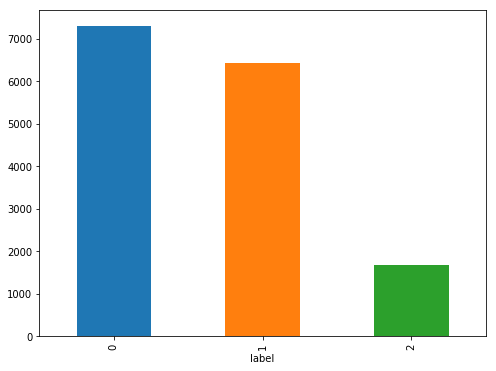

In [168]:
fig = plt.figure(figsize=(8,6))
df2.groupby('label').normalized_en.count().plot.bar(ylim=0)
plt.show()

In [169]:
df2.label.value_counts(normalize=True)

0    0.474015
1    0.416661
2    0.109323
Name: label, dtype: float64

In [170]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df2.normalized_en).toarray()
labels = df2.label
features.shape

(15413, 3471)

In [172]:
X_train, X_test, y_train, y_test = train_test_split(df2['normalized_en'], df2['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [173]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\s3369327\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s3369327\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\s3369327\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\s3369327\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning

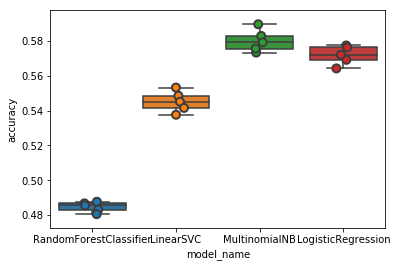

In [174]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [175]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.545190
LogisticRegression        0.571791
MultinomialNB             0.580095
RandomForestClassifier    0.484720
Name: accuracy, dtype: float64

In [142]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df2.index, test_size=0.33, random_state=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [143]:
df2['category_id'] = df2['label'].values
category_id_df = df2[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

In [144]:
df2.tail(10)

,normalized_en,label,category_id
15545,photograph show man,2,2
15546,sign law permanently protect federal funding t...,1,1
15547,really propose aid past,0,0
15548,high tax rate payer single mom get benefit two...,1,1
15549,never knowledge involve legislation hearing is...,0,0
15550,spending bill pork barrel item,2,2
15551,representative push terrorism climate change h...,0,0
15552,repeat tell use,0,0
15553,member public could potentially gain part clas...,2,2
15554,n get information federal government refugee c...,1,1


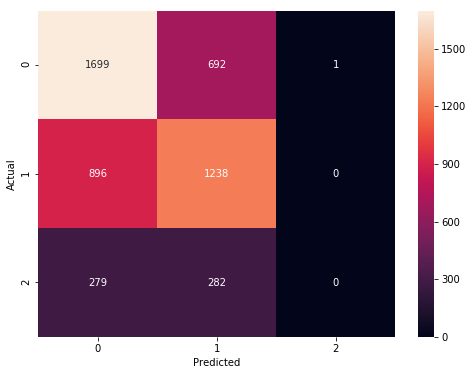

In [145]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [179]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df2.index, test_size=0.33, random_state=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [180]:
df2['category_id'] = df2['label'].values
category_id_df = df2[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

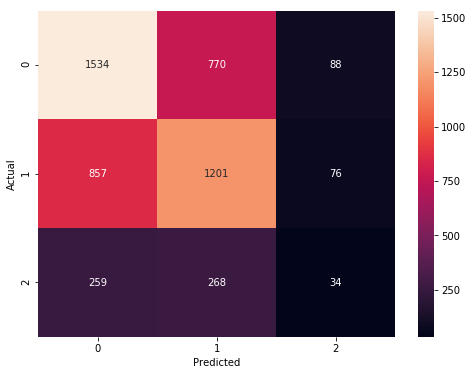

In [181]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [182]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            print('')

'1' predicted as '0' : 857 examples.

'2' predicted as '0' : 259 examples.

'0' predicted as '1' : 770 examples.

'2' predicted as '1' : 268 examples.

'0' predicted as '2' : 88 examples.

'1' predicted as '2' : 76 examples.



In [183]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['label', 'claim']])
            print('')

'1' predicted as '0' : 857 examples.


,label,claim
9983,1,Says up to a quarter of African Americans don’...
15419,1,"Says Hillary Clinton ""viciously"" attacked wome..."
3995,1,"Under Common Core standards, it takes ""more th..."
8542,1,"Obamacare ""was invented by liberal academic th..."
1835,1,"Says California Gov. Jerry Brown ""vetoed 2016 ..."
8338,1,Doctors are now warning parents to never use b...
1335,1,"As the Nazi Party rose to power, Hitler used t..."
11298,1,"Vern Buchanan ""has been completely exonerated""..."
8147,1,“I have no doubt that in terms of cooperation ...
4021,1,Images of xenophobic attacks in South Africa



'2' predicted as '0' : 259 examples.


,label,claim
11243,2,"""An amendment, pushed by Lyndon Johnson many y..."
1859,2,Image shows a fourth-grade science quiz about ...
9460,2,"In August 2017, the owner of a hotel in Arosa,..."
14089,2,"Says Sen. Rand Paul’s 2011 budget ""included a ..."
13801,2,"The words ""subhuman mongrel,"" which Ted Nugent..."
11916,2,"Says 74% of people in Texas are ""crammed into ..."
9113,2,"Cigarette butts ""poison babies and small child..."
2948,2,"Says Scott Walker's ""listening sessions"" are ""..."
3949,2,Burglars returned stolen computers to a group ...
4641,2,"""My property taxes went down largely because m..."



'0' predicted as '1' : 770 examples.


,label,claim
4805,0,"""We lose ... almost all of the lawsuits in th..."
5297,0,"""If you were a Muslim, you could come in, if y..."
13228,0,"Says Barack Obama is the ""first president to a..."
9189,0,"""As a 27 year old staff attorney for the House..."
4290,0,"""ISIS camp a few miles from Texas, Mexican aut..."
14745,0,"Scott Walker's income ""tax plan is a tax hike...."
7534,0,"Says Iran is "" taking over the oil” in Iraq."
13832,0,"Under the North American Free Trade Agreement,..."
9284,0,"Says former Sen. Harry Reid ""got thrown out."""
8596,0,"Says former President Barack Obama ""will be on..."



'2' predicted as '1' : 268 examples.


,label,claim
7006,2,Donna Brazile was fired from CNN after leaked ...
12918,2,Facebook posts by commercial flight attendants...
3830,2,"In Massachusetts, ""half of the primary care do..."
831,2,"""Grateful insurance company executives and the..."
10965,2,"Says $15-an-hour proposal in Cleveland is ""the..."
252,2,"""Less than half of the poorest American househ..."
13773,2,Amazon paid zero dollars in federal income tax...
7841,2,“[Global top 10]… confirms the latest years’ t...
8969,2,McCain has switched to Obama's position on mor...
13766,2,"Ken Buck wants to ""outlaw abortion, even in ca..."



'0' predicted as '2' : 88 examples.


,label,claim
11828,0,Rep. Beto O’Rourke is “against background che...
10137,0,"""Clayton County offers the lowest operating mi..."
14037,0,"The new Apple Watch Series 4 includes ""the fir..."
11246,0,A video shows a man angrily renouncing his fai...
12291,0,"""We have signed more legislation than anybody...."
2118,0,"We have less than 500,000 mortgages. I think i..."
13233,0,"""The Clintons now charge the Secret Service $1..."
14277,0,A Nevada morgue employee was arrested for oper...
13756,0,“There are three states in America that get o...
7261,0,Television journalist Geraldo Rivera was born ...



'1' predicted as '2' : 76 examples.


,label,claim
12232,1,"Marijuana and THC ""have caused emergency room ..."
1236,1,"""Food stamp enrollment drops by four million i..."
2187,1,Anonymous has discovered evidence that numerou...
2636,1,"“Another day, another lie. The reality is that..."
8141,1,"""Many of (Hillary Clinton's) friends took bigg..."
4183,1,"California has ""the same water infrastructure ..."
747,1,"""The Legislative Ethics Commission continues t..."
8154,1,Dolly Parton publicly criticized Hillary Clint...
3027,1,"""Fifty years ago, the average GM employee coul..."
9609,1,"""The top one-tenth of 1 percent"" of Americans ..."
